### Entrega Individual: Alejandro Casanova Martín

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

def readFile(filename : str = 'botnet_tot_syn_l.csv'):
    '''
    filename -- name of the spam dataset file
        
    returns:
        An np.array (Xy) containing the data of filename. 
            Each element is a tuple (X,y).
                “X” is an array containing the 11 features (float number) of an example
                “y” is the 12th column of an example (integer 0/1)
    '''
    
    print(f"Getting input data from file: {filename}")
    # read data in chunks
    chunk = pd.read_csv(filename, chunksize=100000)
    pd_df = pd.concat(chunk)
    pd_df_numpy = pd_df.to_numpy()

    # Format X into an array of tuples ( [X0, X1, X2, ... X10] , y)
    Xy = np.empty(len(pd_df_numpy), dtype=object) # Reserve empty array
    print(f"Formatting input data into array of tuples with shape: ([X0, X1, X2, ... X10] , y)...")
    for i in tqdm(range(len(pd_df_numpy)), desc="Samples: "):
        Xy[i] = (pd_df_numpy[i][:-1], round(pd_df_numpy[i][-1])) # Fill array with tuples in right format
        
    return Xy

In [2]:
def normalize (Xy: np.ndarray):
    '''
    Arguments:
        Xy is a numpy array containing data examples. Each element is a tuple (X,y).
            “X” is an array containing the 11 features (float number) of an example
            “y” is the label of the example (integer 0/1)
    Returns:
        A numpy array rescaled to N(0,1) in each column (mean=0, standard deviation=1)
    '''
    n = len(Xy) # Num of rows (samples)
    k = len(Xy[0][0]) # Num of columns (input variables)
    
    Xy_new = np.empty(n, dtype=object)
    mean = np.zeros(k) # Create array for means of each column
    stddev = np.zeros(k)
    
    print("Dataset normalization in progress...\n")
    
    # Calculate mean array
    print("Calculating mean values...")
    for i in tqdm(range(n), desc="Samples:"):
        mean += Xy[i][0]
    mean /= n
    print(f"Result: {mean}\n")
    
    # Calculate stddev array
    print("Calculating stddev values...")
    for i in tqdm(range(n), desc="Samples:"):
        stddev += np.power(Xy[i][0] - mean, 2)
    stddev /= n
    stddev = np.sqrt(stddev)
    print(f"Result: {stddev}\n")
    
    # Normalize
    print("Normalizing...")
    for i in tqdm(range(n), desc="Samples:"):
        Xy_new[i] = ((Xy[i][0] - mean) / stddev, Xy[i][1])
    
    return Xy_new

In [3]:
import numpy as np

def predict_prob (w, b, x):
    '''
    Auxiliary function! Returns predicted probabilities, NOT predicted labels
    
    Arguments:
        w -- weights
        b -- bias
        x -- Example to be predicted (only 1 example)
    Returns:
        Y_pred_prob -- a float value (0-1) corresponding to the prediction of X
    '''
    
    # Apply model's function
    y_logit = np.dot(w, x) + b
    
    # Apply sigmoid to get prediction probability
    y_pred_prob = 1 / (1 + np.exp(-y_logit)) 
    
    return y_pred_prob

In [4]:
import math
import pandas as pd
from tqdm.notebook import tqdm

NUM_FEATURES = 11
NUM_WEIGHTS = NUM_FEATURES + 1

def train (Xy, iterations, learning_rate):
    '''
    Arguments:
        Xy -- numpy array containing data examples. Each record of the array is a tuple (X,y).
            “X” is an array containing the 11 features (float number) of an example
            “y” is the label of the example (integer 0/1)
        iterations -- number of iterations of the optimization loop
        learning_rate -- learning rate of the gradient descent
    Returns:
        A list or array containing the weights “w” and bias “b” at the end of the
            training process in the shape of [w0, w1, ... w10, b]
    '''
    
    w = np.random.rand(NUM_WEIGHTS) # Weights
    dw = np.zeros(NUM_WEIGHTS) # Derived weights
    m = len(Xy) # Number of samples
    cost_reg = []
    
    print("Training...")
    for it in tqdm(range(iterations), desc="Iterations: "):
        
        # Set cost to 0 before accumulating
        cost = 0
        
        for j in tqdm(range(m), leave=False, desc="Samples: "): # Iterate over data samples
            
            # Unpack single data sample tuple
            X, y = Xy[j]
            
            # Get y_hat for one data sample
            y_pred_prob = predict_prob(w[:-1], w[-1], X) 
            
            # Accumulate cost
            cost += y * math.log(y_pred_prob) + (1 - y) * math.log(1 - y_pred_prob)
            
            # Accumulate for derivatives of all weights except b
            for i in range(NUM_WEIGHTS-1):   
                dw[i] += ( y_pred_prob - y ) * X[i]
                
            # Accumulate for derivative for b
            dw[-1] += y_pred_prob - y
        
        # Divide by number of samples to compute the derivative 
        dw /= m
        
        # Divide by number of samples to compute the cost 
        cost /= -m
        cost_reg.append(cost)
        print(f"Iteration: {it} - Cost: {cost}")
        
        # Update weights
        w -= learning_rate * dw
    
    # Plot cost curve
    df = pd.DataFrame({"Cost": cost_reg}, index=range(1, iterations + 1))
    df.plot(title="Training Cost", xlabel="Iterations")
    
    # Return tuned weights
    return w

In [5]:
import numpy as np

def predict (w, b, x):
    '''
    Arguments:
        w -- weights
        b -- bias
        x -- Example to be predicted (only 1 example)
    Returns:
        Y_pred -- a value (0/1) corresponding to the prediction of X
    '''
    
    # Apply model's function
    y_logit = np.dot(w, x) + b
    
    # Apply sigmoid to get prediction probability
    y_pred_prob = 1 / (1 + np.exp(-y_logit)) 
    
    # Round up to 0 or 1
    y_pred = 1 if y_pred_prob >= 0.5 else 0
    
    return y_pred

In [6]:
def accuracy (w, b, Xy):
    '''    
    Arguments:
        w -- weights
        b -- bias
        Xy -- numpy array containing examples to be predicted
    Returns:
        accuracy -- the number of predictions that are correct divided by the number of 
            records (examples) in Xy.
    '''
    
    m = len(Xy) # Number of samples
    accuracy = 0
    
    print("\nCalculating accuracy...")
    for i in tqdm(range(m), desc="Samples: "):
        
        X, y = Xy[i]
        y_pred = predict(w, b, X)
        
        if y_pred == y:
            accuracy += 1
            
    accuracy /= m
    
    return accuracy

# MAIN Code

Getting input data from file: botnet_tot_syn_l.csv
Formatting input data into array of tuples with shape: ([X0, X1, X2, ... X10] , y)...


Samples:   0%|          | 0/999999 [00:00<?, ?it/s]

Dataset normalization in progress...

Calculating mean values...


Samples::   0%|          | 0/999999 [00:00<?, ?it/s]

Result: [1.28153955e+03 2.12827868e+04 6.94806411e+03 6.26312587e+04
 1.22198717e+08 1.57222518e+07 9.10731004e+00 1.88975369e+00
 1.24270085e+02 2.13060268e+09 2.26149160e+09]

Calculating stddev values...


Samples::   0%|          | 0/999999 [00:00<?, ?it/s]

Result: [1.60589352e+03 2.41174791e+04 1.63949521e+04 1.34264271e+05
 2.33920799e+08 4.41237988e+07 5.28172701e+00 2.10134637e+00
 9.03431365e+01 7.13843720e+08 1.30153258e+09]

Normalizing...


Samples::   0%|          | 0/999999 [00:00<?, ?it/s]

Training...


Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

Samples:   0%|          | 0/999999 [00:00<?, ?it/s]

Iteration: 0 - Cost: 1.270309883029273


Samples:   0%|          | 0/999999 [00:00<?, ?it/s]

Iteration: 1 - Cost: 0.7159412731131078


Samples:   0%|          | 0/999999 [00:00<?, ?it/s]

Iteration: 2 - Cost: 0.482236725004454


Samples:   0%|          | 0/999999 [00:00<?, ?it/s]

Iteration: 3 - Cost: 0.37590080615140653


Samples:   0%|          | 0/999999 [00:00<?, ?it/s]

Iteration: 4 - Cost: 0.31933745330207647


Samples:   0%|          | 0/999999 [00:00<?, ?it/s]

Iteration: 5 - Cost: 0.28530882929654755


Samples:   0%|          | 0/999999 [00:00<?, ?it/s]

Iteration: 6 - Cost: 0.26284857446389437


Samples:   0%|          | 0/999999 [00:00<?, ?it/s]

Iteration: 7 - Cost: 0.246991289835358


Samples:   0%|          | 0/999999 [00:00<?, ?it/s]

Iteration: 8 - Cost: 0.23522421517190506


Samples:   0%|          | 0/999999 [00:00<?, ?it/s]

Iteration: 9 - Cost: 0.2261544715168657

Calculating accuracy...


Samples:   0%|          | 0/999999 [00:00<?, ?it/s]

Accuracy: 92.4257


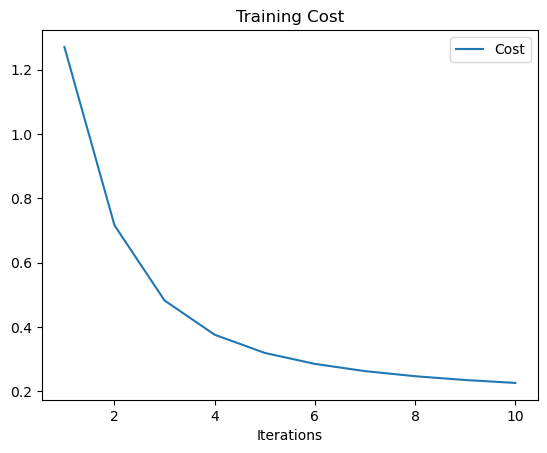

In [7]:
NUM_ITER = 10
LR = 1.5

# Read data from file
Xy = readFile('botnet_tot_syn_l.csv')

# Normalize data
Xy_normalized = normalize(Xy)

# Train Model
w = train(Xy_normalized, NUM_ITER, LR)

# Calculate Accuracy
acc = accuracy(w[:-1], w[-1], Xy_normalized)
print(f"Accuracy: {(acc*100):.4f} %")